**Лекция 9**

# Обусловленность СЛАУ #

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Суть-проблемы" data-toc-modified-id="Суть-проблемы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Суть проблемы</a></span></li><li><span><a href="#Обусловленность" data-toc-modified-id="Обусловленность-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обусловленность</a></span><ul class="toc-item"><li><span><a href="#Число-обусловленности" data-toc-modified-id="Число-обусловленности-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Число обусловленности</a></span></li><li><span><a href="#Геометрическая-интерпретация" data-toc-modified-id="Геометрическая-интерпретация-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Геометрическая интерпретация</a></span></li></ul></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Линейная регрессия</a></span><ul class="toc-item"><li><span><a href="#Генерация-данных" data-toc-modified-id="Генерация-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Генерация данных</a></span></li><li><span><a href="#Поиск-коэффициентов-регрессии" data-toc-modified-id="Поиск-коэффициентов-регрессии-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Поиск коэффициентов регрессии</a></span></li><li><span><a href="#Сингулярное-разложение" data-toc-modified-id="Сингулярное-разложение-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Сингулярное разложение</a></span></li></ul></li><li><span><a href="#Проблема-мультиколлинеарности" data-toc-modified-id="Проблема-мультиколлинеарности-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проблема мультиколлинеарности</a></span><ul class="toc-item"><li><span><a href="#Метод-главных-компонент" data-toc-modified-id="Метод-главных-компонент-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Метод главных компонент</a></span></li></ul></li><li><span><a href="#Источники" data-toc-modified-id="Источники-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Источники</a></span></li></ul></div>

In [1]:
# Imports
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
# Styles
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['lines.markersize'] = 4
cm = plt.cm.tab10  # Colormap

import seaborn
seaborn.set_style('whitegrid')

In [3]:
import warnings
warnings.filterwarnings('ignore')

# %config InlineBackend.figure_formats = ['pdf']
# %config Completer.use_jedi = False

---

## Суть проблемы ##

Пусть дана исходная система линейных уравнений
$$ A \mathbf{x} = \mathbf{b}, $$
где $A$ &mdash; квадратная невырожденная матрица порядка $n$.

В этом случае система имеет единственное решение $\mathbf{x} = A^{-1} \mathbf{b}$.

Решение системы линейных уравнений можно интерпретировать, как разложение вектора $\mathbf{b}$ по вектор-столбцам матрицы $A$.

Рассмотрим матрицу
$$
  A = 
  \begin{pmatrix}
    1.0 & 0.9 \\
    1.0 & 1.1
  \end{pmatrix}.
$$

Её столбцы, практически, коллинеарны.

In [4]:
A = np.array([[1.0, 0.9],
              [1.0, 1.1]])

origin = [[0,0], [0,0]] # origin point

In [5]:
def make_decor(ax, xlims=None, ylims=None):
    for axi in ax:
        axi.axhline(y=0, color='k')
        axi.axvline(x=0, color='k')
        axi.set_xlabel('$x_1$')
        axi.set_ylabel('$x_2$', rotation=0, ha='right')
        if(xlims):
            axi.set_xlim(xlims)
            axi.set_ylim(ylims)
        axi.set_aspect('equal')
        axi.set_axisbelow(True)

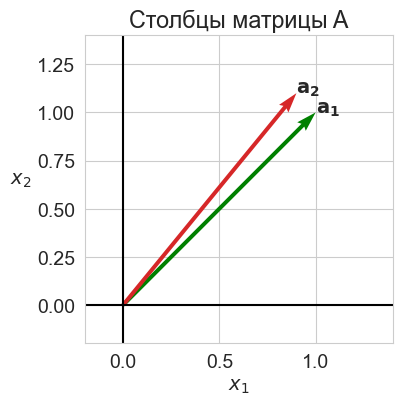

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.subplots_adjust(wspace=0.4)
make_decor([ax], [-0.2, 1.4], [-0.2, 1.4])

# Plotting A
ax.quiver(*origin, A[0,:], A[1,:], color=['g', cm(3)],
          width=0.013, angles='xy', scale_units='xy', scale=1)
ax.set_title("Столбцы матрицы A")
ax.text(*A[:,0], "$\mathbf{a_1}$")
ax.text(*A[:,1], "$\mathbf{a_2}$")

plt.show()

Из общих соображений понятно, что выбирать эти столбцы в качестве базисных &mdash; плохая идея.
Посмотрим, какие проблемы могут появиться.

Пусть вектор $\mathbf{b}$ известен не точно, а с некоторой погрешностью.
Посмотрим, какова будет погрешность решения системы &mdash; вектора $\mathbf{x}$.

> Здесь и далее на рисунках вектор правых частей изображается на *правом* рисунке (&laquo;После преобразования&raquo;), а вектор решения &mdash; на *левом* (&laquo;До преобразования&raquo;).

In [7]:
U, sgm, Vt = LA.svd(A)
mu = sgm[0]/sgm[1]

In [8]:
# Creating perturbed vectors B and solve system
# Solution
x = np.zeros((400, 1))
alpha = np.radians(45)
b0 = np.atleast_2d([np.cos(alpha), np.sin(alpha)]).T  # 1
# b0 = -np.atleast_2d(U[:,0]).T  # 2
# b0 = np.atleast_2d(U[:,1]).T  # 3
A_inv = LA.inv(A)
x0 = A_inv @ b0
print(x0)

# Noise
n = 100
np.random.seed(42)
r = 0.1*np.random.rand(n)
phi = 2*np.pi*np.random.rand(n)
B1 = b0[0] + r*np.cos(phi)
B2 = b0[1] + r*np.sin(phi)
B = np.vstack((B1, B2))
X = A_inv @ B

[[0.70710678]
 [0.        ]]


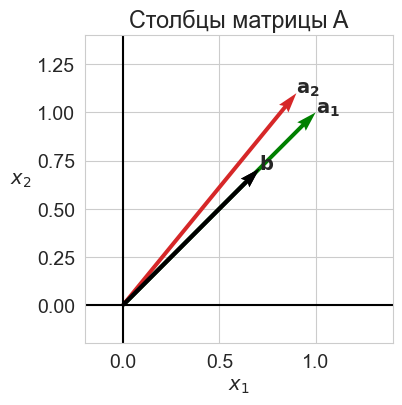

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.subplots_adjust(wspace=0.4)
make_decor([ax], [-0.2, 1.4], [-0.2, 1.4])

# Plotting A
ax.quiver(*origin, A[0,:], A[1,:], color=['g', cm(3)],
          width=0.013, angles='xy', scale_units='xy', scale=1)
ax.quiver(*origin, b0[0,:], b0[1,:], color=['k'],
          width=0.013, angles='xy', scale_units='xy', scale=1)
ax.set_title("Столбцы матрицы A")
ax.text(*A[:,0], "$\mathbf{a_1}$")
ax.text(*A[:,1], "$\mathbf{a_2}$")
ax.text(*b0, "$\mathbf{b}$")

plt.show()

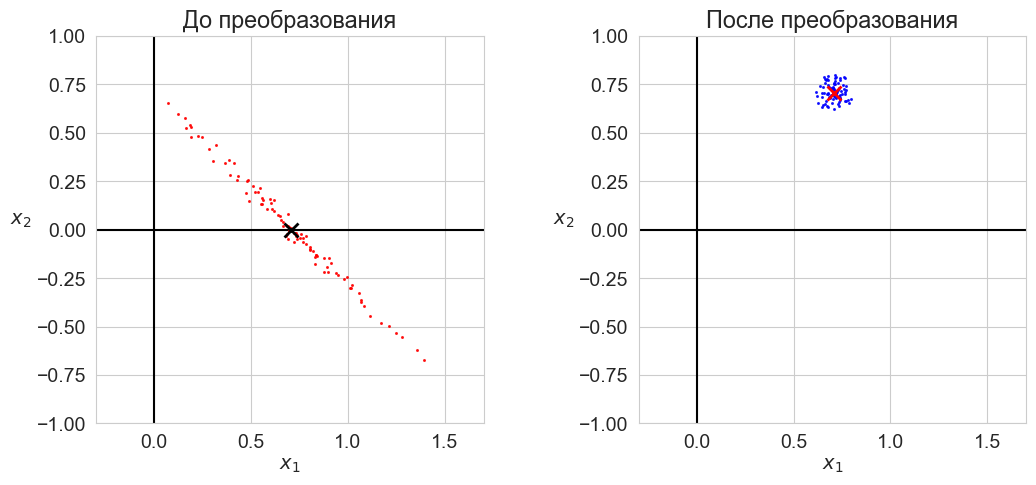

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplots_adjust(wspace=0.4)
xlims = [-0.3, 1.7]
ylims = [-1.0, 1.0]
make_decor(ax, xlims, ylims)
# make_decor(ax)

# Plotting X
ax[0].plot(X[0,:], X[1,:], 'ro', ms=1.2, alpha=0.8)
ax[0].plot(x0[0], x0[1], 'kx', ms=10, mew=2)
ax[0].set_title("До преобразования")

# Plotting B
ax[1].plot(B[0, :], B[1, :], 'bo', ms=1.2, alpha=0.8)
ax[1].plot(b0[0], b0[1], 'rx', ms=10, mew=2)
ax[1].set_title("После преобразования")

plt.show()

In [11]:
# x_sol = np.array([1.0, 0.0]).T
dx = X - x0
db = B - b0

k1 = np.array(list(map(LA.norm, db.T))) / LA.norm(b0)
k2 = np.array(list(map(LA.norm, dx.T))) / LA.norm(x0)

print(f'Максимальное относительное увеличение возмущения max(dx/x : db/b) = {max(k2/k1):.5g}')

Максимальное относительное увеличение возмущения max(dx/x : db/b) = 14.156


Мы видим, что небольшое возмущение вектора правой части $\mathbf{b}$ привела к гораздо большим (примерно в 14 раз) возмущениям вектора решений $\mathbf{x}$.
В таком случае говорят, что система уравнений является *плохо обусловленной*.
Разберёмся подробнее, что это значит.

> **Самостоятельно.**
Проблема в том, что мы пытаемся разложить вектор $\mathbf{b}$ по базису, векторы которого почти коллинеарны. Тогда почему бы нам не попытаться ортогонализовать наш базис, применив, например, $QR$-разложение?

---

## Обусловленность ##

### Число обусловленности

Рассмотрим возмущённую систему
$$
  A \tilde{\mathbf{x}} = \mathbf{b} + \delta\mathbf{b}.
$$

Введём вектор возмущения решения $\delta \mathbf{x} = \tilde{\mathbf{x}} - \mathbf{x}$.

Выразим $\mathbf{x}$ и $\delta\mathbf{x}$ через обратную матрицу $A^{-1}$:
$$
  \delta \mathbf{x} = A^{-1}(\mathbf{b} + \delta\mathbf{b}) - A^{-1}\mathbf{b} = A^{-1}\delta\mathbf{b}.
$$

Перейдём к оценке нормы возмущения:
$$
  \frac{\|\delta \mathbf{x}\|}{\|\mathbf{x}\|} = \frac{\|A^{-1} \delta \mathbf{b}\|}{\|\mathbf{x}\|} \le \frac{\|A^{-1}\| \cdot \|\mathbf{b}\|}{\|\mathbf{x}\|} \cdot \frac{\|\delta \mathbf{b}\|}{\|\mathbf{b}\|}.
$$

Мы получили связь между относительной погрешностью решения и относительной погрешностью правой части системы уравнений.

Величина
$$
  \nu(A, b) = \dfrac{\|A^{-1}\| \cdot \|\mathbf{b}\|}{\|\mathbf{x}\|} = \dfrac{\|A^{-1}\| \cdot \|\mathbf{b}\|}{\|A^{-1} \mathbf{b}\|}
$$
называется *числом обусловленности системы при заданной правой части* и показывает, во сколько раз может возрасти относительная погрешность решения по сравнению с относительной погрешностью правой части.

Учитывая, что $\|\mathbf{b}\| \le \|A\| \cdot \|\mathbf{x}\|$, усилим неравенство, заменив $\|\mathbf{b}\|$ на $\|A\| \|\mathbf{x}\|$:
$$
  \frac{\|\delta \mathbf{x}\|}{\|\mathbf{x}\|}
  \le \frac{\|A^{-1}\| \cdot \|\mathbf{b}\|}{\|\mathbf{x}\|} \cdot \frac{\|\delta \mathbf{b}\|}{\|\mathbf{b}\|}
  \le \frac{\|A^{-1}\| \cdot \|A\| \|\mathbf{x}\|}{\|\mathbf{x}\|} \cdot \frac{\|\delta \mathbf{b}\|}{\|\mathbf{b}\|}
  = \|A^{-1}\| \|A\| \frac{\|\delta \mathbf{b}\|}{\|\mathbf{b}\|}.
$$

Мы получили универсальную, не зависящую от правой части оценку сверху числа обусловленности системы. Данная оценка достигается, когда $\|A\mathbf{x}\| = \|A\| \|\mathbf{x}\|$.

**Определение.**
Величина $\mu(A) = \|A^{-1}\| \|A\|$ называется *числом обусловленности матрицы* $A$ в рассматриваемой норме. Она показывает, во сколько раз может возрасти относительная погрешность решения по сравнению с относительной погрешностью правой части.

Число обусловленности определяется не только матрицей, но и выбором нормы.
Рассмотрим один из наиболее употребительных вариантов &mdash; *спектральное число обусловленности*.
Согласно формуле для спектральной нормы матрицы
$$
  \mu_e(A) = \dfrac{\sigma_{\max}}{\sigma_{\min}}.
$$

Геометрически $\mu_e(A)$ показывает, насколько неравномерно преобразование $A$ растягивает пространство по своим главным направлениям.

In [12]:
U, sgm, Vt = LA.svd(A)
mu = sgm[0]/sgm[1]
print('sigma = ', np.round(sgm, 3))
print('mu(A) = ', round(mu, 5))

sigma =  [2.003 0.1  ]
mu(A) =  20.05012


### Геометрическая интерпретация ###

Дадим геометрическую интерпретацию числа обусловленности.

In [13]:
# Creating the vectors for a circle and storing them in x
r_b = 0.1 * LA.norm(b0)
phi = np.linspace(0, 2*np.pi, 200)
B1 = b0[0] + r_b*np.cos(phi)
B2 = b0[1] + r_b*np.sin(phi)
Bc = np.vstack((B1, B2))

#
A_inv = LA.inv(A)
x0 = A_inv @ b0
Xc = A_inv @ Bc

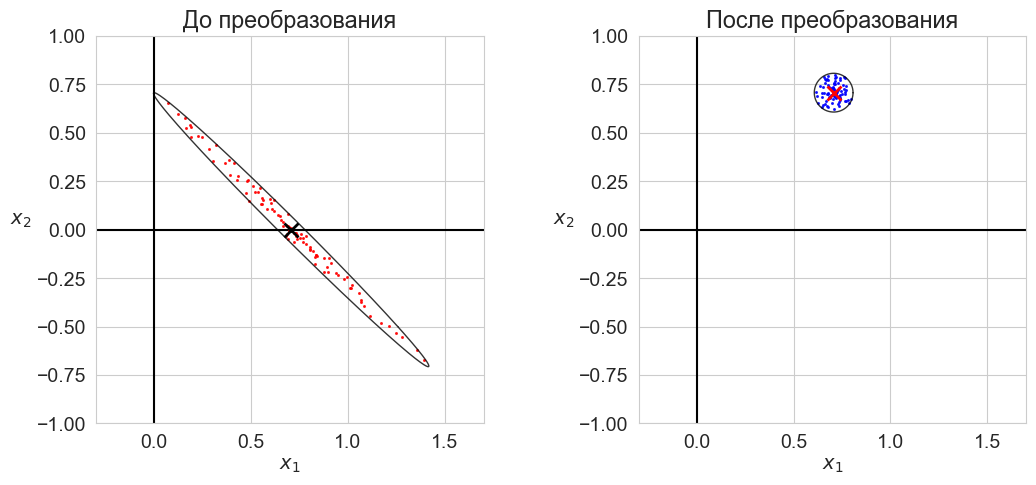

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplots_adjust(wspace=0.4)
make_decor(ax, xlims, ylims)

# Plotting X
ax[0].plot(X[0,:], X[1,:], 'ro', ms=1.2, alpha=.8)
ax[0].plot(Xc[0,:], Xc[1,:], lw=1., c='k', alpha=.8)
ax[0].plot(x0[0], x0[1], 'kx', ms=10, mew=2)
ax[0].set_title("До преобразования")

# Plotting B
ax[1].plot(B[0,:], B[1,:], 'bo', ms=1.2, alpha=.8)
ax[1].plot(Bc[0, :], Bc[1, :], lw=1., c='k', alpha=.8)
ax[1].plot(b0[0], b0[1], 'rx', ms=10, mew=2)
ax[1].set_title("После преобразования")

plt.show()

Для двумерного случая мы видим, что если векторы правой части возмущённой системы лежат внутри окружности, то решения возмущённой системы лежат внутри эллипса, являющегося прообразом этой окружности.
Причём отношение полуосей этого эллипса равно *спектральному числу обусловленности*.

> **Самостоятельно**
>
> 1. В нашем примере число обусловленности $\mu(A) \approx 20$. Но выше мы нашли, что относительная погрешность увеличилась только в $14$ раз. Почему так произошло? При каком условии будет достигаться оценка, сделанная по числу обусловленности матрицы?
> 2. Если известен вектор $\mathbf{b}$, как сделать более точную оценку возрастания относительной погрешности?

---

## Линейная регрессия ##

### Генерация данных ###

In [15]:
def pol(a, x):
    return np.sum([a[i]*x**i for i in range(len(a))], axis=0)

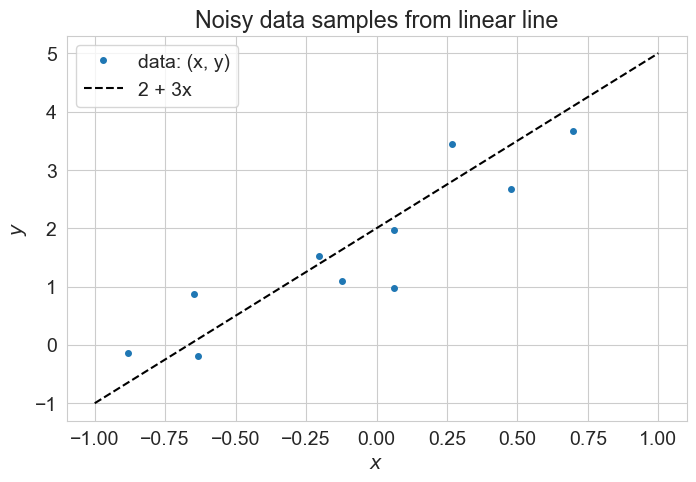

In [16]:
# Define the data
np.random.seed(123)
Ns = 10 # Number of samples
x_lim = np.array([-1, 1])

# Underlying functional relation
fun = pol
a = [2, 3]
label = f'{a[0]} + {a[1]}x'

# Noise
e_std = 0.5  # Standard deviation of the noise
err = e_std * np.random.randn(Ns)  # Noise

# Features and output
x = np.random.uniform(x_lim[0], x_lim[1], Ns)  # Independent variable x
y = fun(a, x) + err  # Dependent variable

# Show data
Nx = int(1e3) # Number of points
X = np.linspace(x_lim[0], x_lim[1], Nx)
plt.figure(figsize=(8, 5))
plt.title('Noisy data samples from linear line')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

### Поиск коэффициентов регрессии ###

In [17]:
# The number of features
Nf = 7
# Stack X with ones to be fitted by OLS
F = np.atleast_2d(np.ones_like(x))
for i in range(1, Nf):
    F = np.vstack((F, x**i))
F = F.T
    
# Fit parameters with OLS
Alpha = np.linalg.inv(F.T @ F) @ F.T @ y

# Function representing fitted line
f = lambda x: sum([Alpha[i]*x**i for i in range(Nf)])

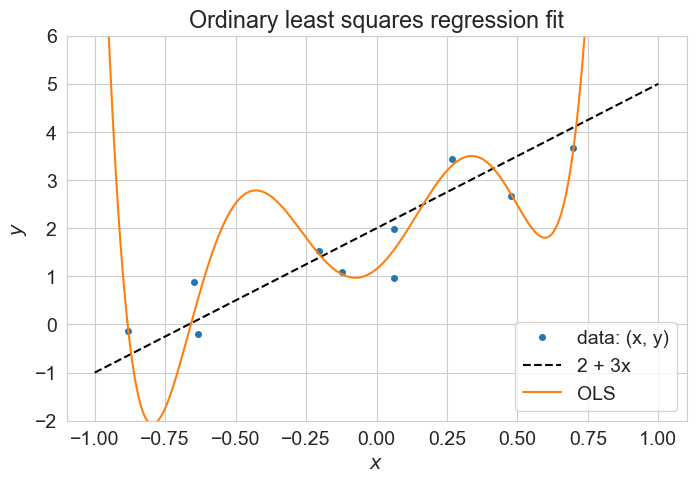

In [18]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Ordinary least squares regression fit')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.legend(loc='lower right')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

### Сингулярное разложение ###

Рассмотрим матрицу $F$ размерностью $m \times n$.
Для определённости будем считать, что строк не меньше чем столбцов и столбцы линейно независимы, т.е. $n \le m$ и $\mathrm{Rg}F = n$.

Представим матрицу $F$ в виде сингулярного разложения 
$$ F = U \Sigma V^\top. $$


Имея сингулярное разложение, легко записать

 - псевдообратную матрицу:
$$ F^{+} = (F^\top F)^{-1}F^\top = (V \Sigma U^\top U \Sigma V^\top)^{-1} \cdot V \Sigma U^\top = V \Sigma^{-1}U^\top = \sum_{j=1}^n \frac{1}{{\sigma_j} }v_j u_j^\top;  \label{eq:psevdo}\tag{1} $$
 
 - вектор МНК-решения:
$$ \alpha^* = F^{+} y  = V \Sigma^{-1}U^\top y = \sum_{j=1}^n \frac{1}{{\sigma_j}}v_j (u_j^\top y);  \label{eq:alpha-res}\tag{2} $$
 
 - вектор $F\alpha^*$ &mdash; МНК-аппроксимацию целевого вектора $y$:
$$ F\alpha^* = P_F y = FF^{+}y = U \Sigma V^\top \cdot V \Sigma^{-1}U^\top y = UU^\top y = \sum_{j=1}^n u_j (u_j^\top y);  \label{eq:F-alpha-res}\tag{3} $$
 
 - норму вектора коэффициентов:
$$ \Vert \alpha^* \Vert^2 = y^\top U \Sigma^{-1}V^\top \cdot V \Sigma^{-1}U^\top y = y^\top U \Sigma^{-2}U^\top y = \sum_{j=1}^n \frac{1}{\sigma_j^2} (u_j^\top y)^2.  \label{eq:alpha-res-norm}\tag{4} $$

---

## Проблема мультиколлинеарности ##

Если ковариационная матрица $K = F^\top F$ имеет неполный ранг, то её обращение невозможно.
Тогда приходится отбрасывать линейно зависимые признаки или применять описанные ниже методы &mdash; регуляризацию или метод главных компонент.
На практике чаще встречается проблема *мультиколлинеарности* &mdash; когда матрица $K$ имеет полный ранг, но близка к некоторой матрице неполного ранга.
Тогда говорят, что $K$ &mdash; матрица неполного псевдоранга или что она плохо обусловлена.
Геометрически это означает, что объекты выборки сосредоточены вблизи линейного подпространства меньшей размерности $m < n$.
Признаком мультиколлинеарности является наличие у матрицы $K$ собственных значений, близких к нулю.

Итак, матрица $K$ плохо обусловлена (матрица считается плохо обусловленной, если $\mu(K) \gtrsim 10^2 \div 10^4$).
Обращение такой матрицы численно неустойчиво.
При умножении обратной матрицы на вектор относительная погрешность усиливается в $\mu(K)$ раз.

Именно это и происходит с МНК-решением в случае плохой обусловленности.
В формуле ([4](#mjx-eqn-eq:alpha-res-norm)) близкие к нулю собственные значения оказываются в знаменателе, в результате увеличивается разброс коэффициентов $\alpha^*$, появляются большие по абсолютной величине положительные и отрицательные коэффициенты.
МНК-решение становится неустойчивым &mdash; малые погрешности измерения признаков или ответов
у обучающих объектов могут существенно повлиять на вектор решения $\alpha^*$, а погрешности измерения признаков у тестового объекта $x$ &mdash; на значения функции регрессии $g(x, \alpha^*)$.
Мультиколлинеарность влечёт не только неустойчивость и переобучение, но и неинтерпретируемость коэффициентов, так как по абсолютной величине коэффициента $\alpha_j$ становится невозможно судить о степени важности признака $f_j$.

Отметим, что проблема мультиколленеарности никак не проявляется на обучающих данных: вектор $F\alpha^*$ не зависит от собственных значений $\sigma$ (см. формулу ([3](#mjx-eqn-eq:F-alpha-res))).

Убедимся в этом для нашего примера.

In [19]:
print('Вектор коэффициентов:', np.round(Alpha, 1))
print('Его норма:', round(LA.norm(Alpha), 1))

print('\nВектор МНК-аппроксимации:', np.round(F @ Alpha, 1))
print('Его норма:', round(LA.norm(F @ Alpha), 1))

print('\nЦелевой вектор:', np.round(y, 1))

Вектор коэффициентов: [   1.2    4.8   29.4  -36.1 -134.8   67.4  154.8]
Его норма: 221.1

Вектор МНК-аппроксимации: [ 1.  -0.1  1.5  2.7  0.5  0.2  1.6  1.6  3.3  3.7]
Его норма: 6.3

Целевой вектор: [ 1.1 -0.1  1.5  2.7 -0.2  0.9  1.   2.   3.4  3.7]


Мы рассмотрим три метода решения проблемы мультиколлинеарности:

1. метод главных компонент,
1. гребневая регрессия,
1. метод LASSO.

### Метод главных компонент ###

Сделаем сингулярное разложение матрицы $F$.
Посмотрим на набор её сингулярных чисел и число обусловленности.

In [20]:
U, sgm, Vt = np.linalg.svd(F, full_matrices=False)
V = Vt.T
print('Сингулярные числа: ' + ', '.join([f'{item:.2g}' for item in sgm]))

mu = (sgm[0]/sgm[-1])
print(f'Число обусловленности mu = {mu:.3g}')

Сингулярные числа: 3.4, 1.8, 0.85, 0.35, 0.14, 0.028, 0.005
Число обусловленности mu = 675


In [21]:
S_s = sum(sgm)
eds = list(map(lambda i: sum(sgm[i:]) / S_s, range(len(sgm))))

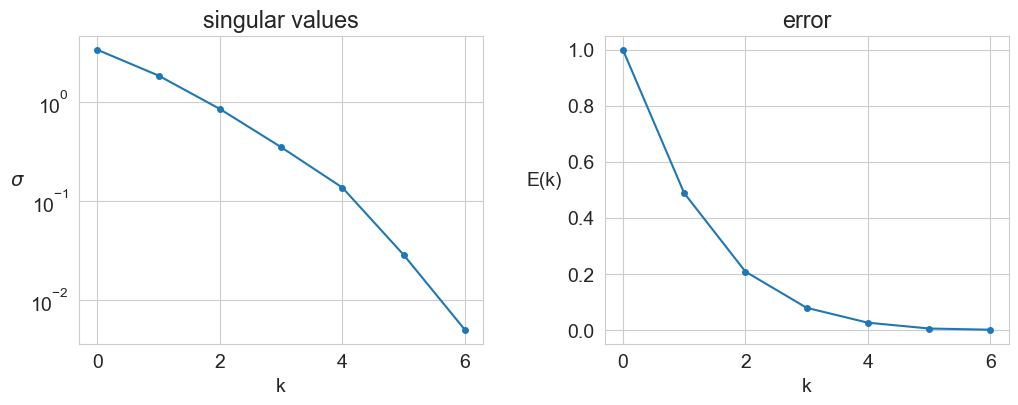

In [22]:
# seaborn.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

ax1.plot(sgm, 'o-')
ax1.set_title('singular values')
ax1.set_yscale('log')
ax1.set_xlabel('k')
ax1.set_ylabel('$\sigma$', rotation=0, ha='right')

ax2.plot(eds, 'o-')
ax2.set_title('error')
ax2.set_xlabel('k')
ax2.set_ylabel('E(k)', rotation=0, ha='right')

plt.show()

Из всего спектра оставим $k$ главных компонент.
Для этого в формуле ([3](#mjx-eqn-eq:eq:alpha-res)) ограничим сумму $k$ слагаемыми.

Получим новый вектор коэффициентов, его норма значительно уменьшилась.

In [23]:
k = 2
# Fit parameters with SVD
Alpha_PCA = sum([1/sgm[i] * V[:,i] * (U.T[i] @ y) for i in range(k)])

# Function representing fitted line
f_PCA = lambda x: sum([Alpha_PCA[i]*x**i for i in range(Nf)])

In [24]:
print('Вектор коэффициентов:', np.round(Alpha_PCA, 2))
print(f'Норма вектора коэффициентов: {LA.norm(Alpha_PCA):.3g}')

Вектор коэффициентов: [ 1.9   1.6  -0.08  0.81 -0.22  0.48 -0.21]
Норма вектора коэффициентов: 2.68


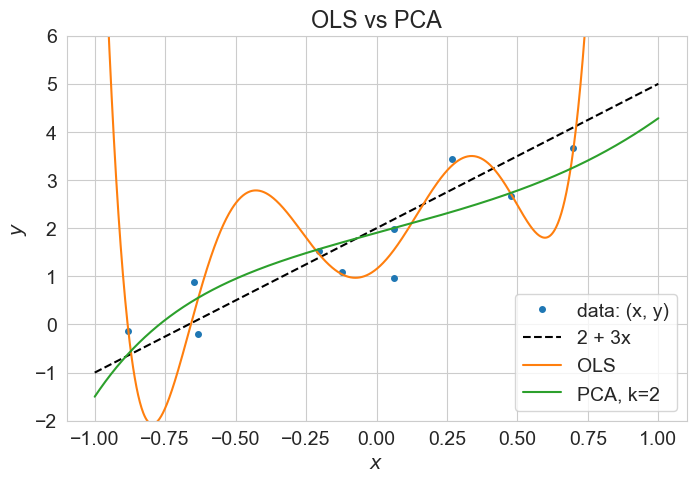

In [25]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('OLS vs PCA')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.plot(X, f_PCA(X), '-', label=f'PCA, k={k}')
plt.legend(loc=4)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

Мы видим, что больших коэффициентов регрессии больше нет, норма вектора коэффициентов уменьшилась на несколько порядков раз.
При этом отметим, что порядок регрессионного полинома не уменьшился, уменьшились коэффициенты при старших членах.
Это означает, что применяя метод главных компонент, мы не избавляемся от менее значимых признаков, а просто уменьшаем их коэффициент в уравнении регрессии.

---

## Источники ##

1. *Беклемишев Д.В.* Дополнительные главы линейной алгебры. &mdash; М.: Наука, 1983. &mdash; 336 с.
1. *Воронцов К.В.* [Математические методы обучения по прецедентам (теория обучения машин)](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf). &mdash; 141 c.

In [26]:
# Versions used
import sys
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(seaborn.__version__))

Python: 3.7.16
numpy: 1.20.3
matplotlib: 3.5.1
seaborn: 0.12.2
